In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import ssm
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import scipy
import scipy.io
import tsfresh
import dtale
import os
px.set_mapbox_access_token("pk.eyJ1IjoibWlrb2xhanNsdXBpbnNraSIsImEiOiJjazJ5dDI0MWEwOTA3M2hxanRwbmo4NDRuIn0.NSbj3B1Bm6fC5QUP3s-BjQ")
import plotly.io as pio
pio.renderers.default = "iframe"
import dask
from lib.huawei import load_data, load_motion, load_ambient, load_battery, load_api, load_label
import tables
from ssm.util import random_rotation, find_permutation
import logging
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
logging.basicConfig(filename='huawei_hmm.log', level=logging.DEBUG)

In [2]:
MODELS_PATH = "../Models/hmm/"

In [3]:
with open("../Data/huawei-competition/selected_features.pickle", "rb") as ifile:
    selected_features = pickle.load(ifile)

In [4]:
data = []
for selected_feature in selected_features:
#     file_path = os.path.join("../Data/2012.01.17-huawei/splitted/", f"1.3a-stationary_50ms__{selected_feature}.csv")
#     df = pd.read_csv(file_path, parse_dates = ["DATETIME_UTC"], index_col="DATETIME_UTC")
    a = np.load(os.path.join("../", selected_feature))
    data.append(a)
#     print(df.shape)
data = np.stack(data, axis=1)

In [5]:
labels = np.load("../Data/huawei-competition/resampled/Label.npy")[:,-1].astype(int) - 1

In [6]:
order = np.loadtxt("../Data/huawei-competition/train_order.txt").astype(int)

In [7]:
data_ordered = np.zeros(data.shape)

In [8]:
data_ordered[order - 1, :] = data

In [9]:
labels_ordered = np.zeros(labels.shape)
labels_ordered[order - 1] = labels

In [10]:
n = int(data_ordered.shape[0]*0.25)
m = int(data_ordered.shape[0]*0.5)
X_train = data_ordered[m:]
y_train = labels_ordered[m:]
X_val = data_ordered[:n]
y_val = labels_ordered[:n]
X_test = data_ordered[n:m]
y_test = labels_ordered[n:m]

In [11]:
def load_model(path):
    with open(path, "rb") as ifile:
        model_dic = pickle.load(ifile)
    return model_dic

In [12]:
models_dic = {}
for f in os.listdir(MODELS_PATH):
    models_dic[f] = load_model(os.path.join(MODELS_PATH, f))

In [14]:
for f in os.listdir("../Models/hmm_parallel/"):
    models_dic[f] = load_model(os.path.join("../Models/hmm_parallel/", f))

In [18]:
np.unique(y_train, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([1176,  949,  338, 1110, 1195,  993, 1455,  939]))

In [15]:
def plot_states(data_z, z_est, label, prefix):
    titles = ["True", label]
    states_list = [data_z, z_est]
    fig, axs = plt.subplots(2,1, figsize=(6,4))
    for (i, ax, states) in zip(range(len(axs)), axs, states_list):
        ax.imshow(states[None,:], aspect="auto")
        ax.set_yticks([])
        ax.set_title(titles[i])
        if i < (len(axs) - 1):
            ax.set_xticks([])

    plt.suptitle(f"{titles[0]} and {titles[1]}", va="baseline")
    plt.tight_layout()
    plt.savefig(f"../Plots/hmm/{prefix}_{titles[0]}_{titles[1]}.pdf")
    plt.show()

In [19]:
# from collections import defaultdict
mutual_informations = {}

huawei_hmm_recurrent_diagonal_gaussian_10_10000_random


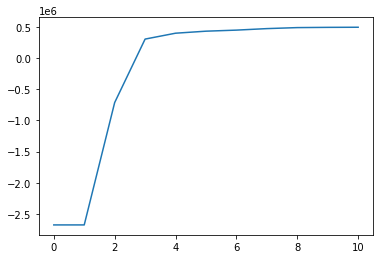

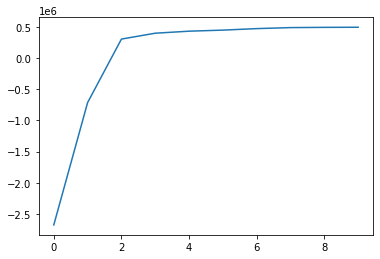

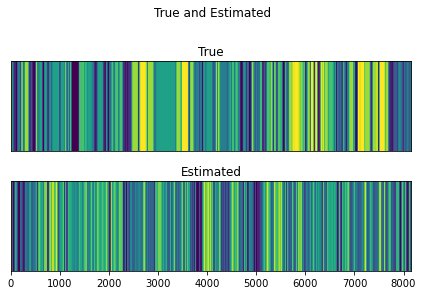

0.06437768240343347


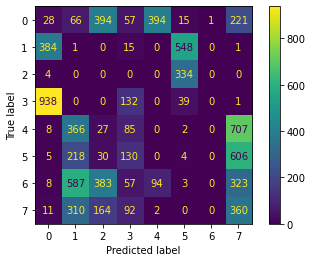

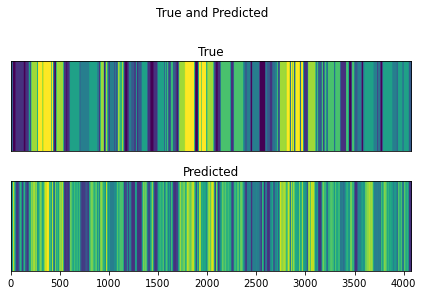

0.4277655138582291


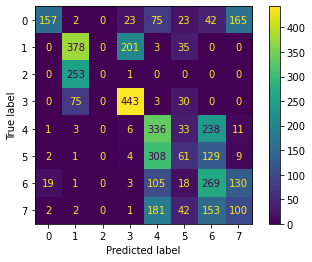

huawei_hmm_recurrent_diagonal_gaussian_1000_10000_random


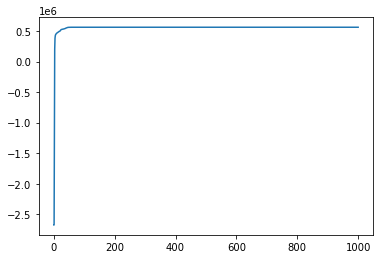

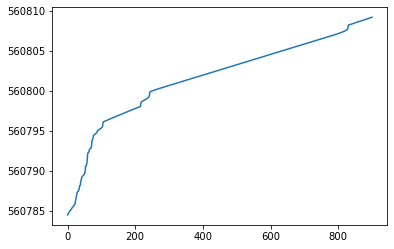

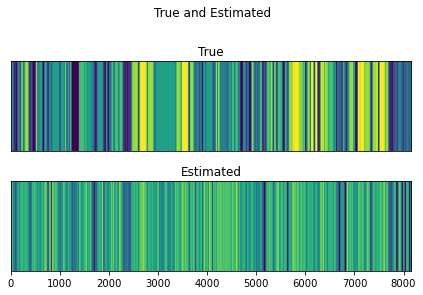

0.1043531575720417


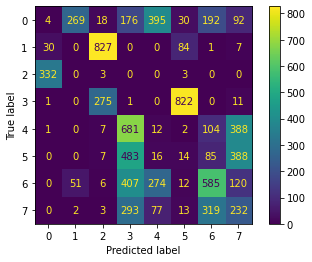

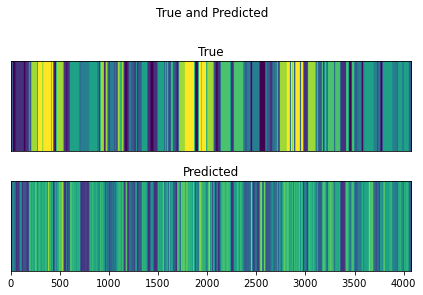

0.5008584743684081


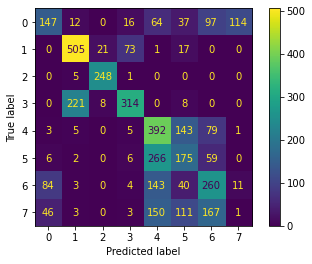

huawei_hmm_recurrent_diagonal_gaussian_1000_10000_kmeans


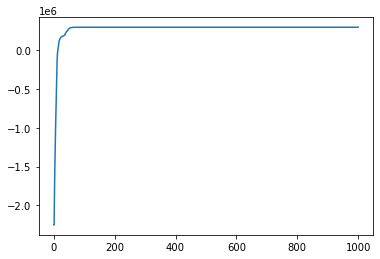

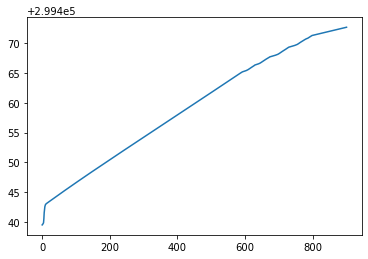

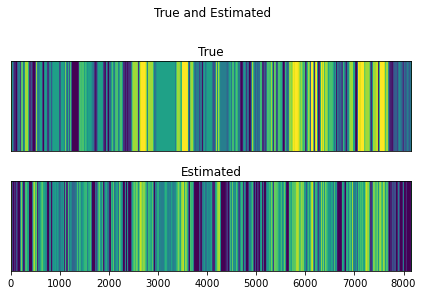

0.08301655426118945


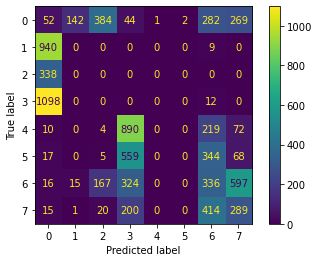

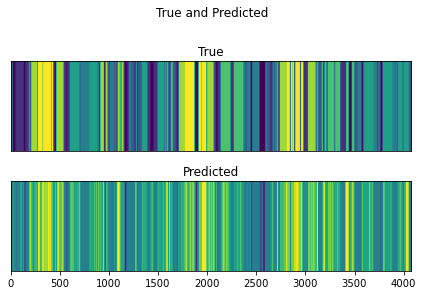

0.4020112828059848


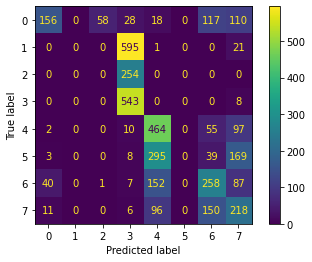

huawei_hmm_recurrent_diagonal_gaussian_10000_10000_random


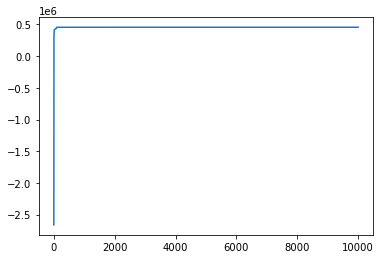

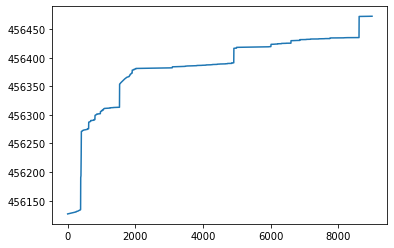

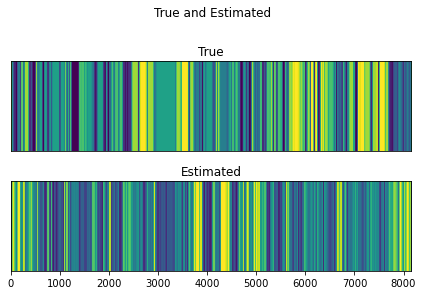

0.021704475781729002


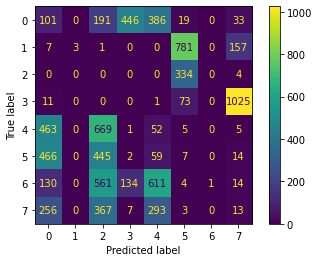

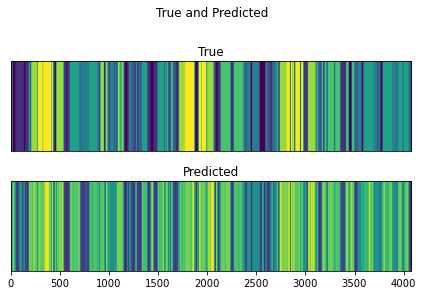

0.48123620309050774


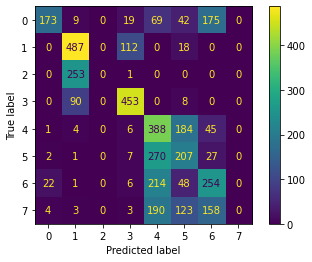

huawei_hmm_recurrent_diagonal_gaussian_10000_10000_kmeans


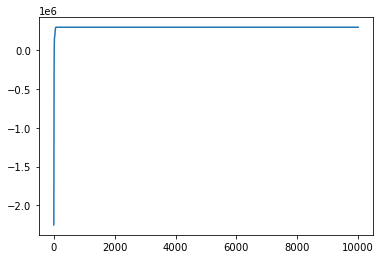

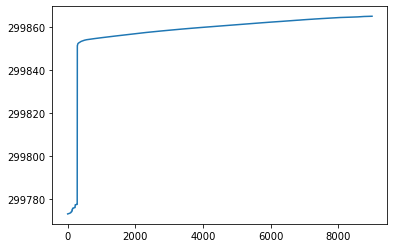

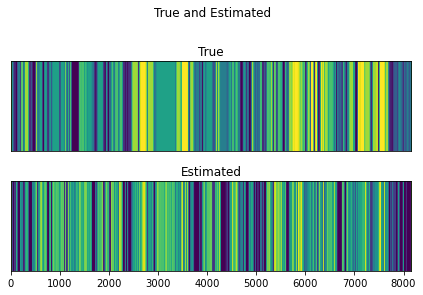

0.1460453709380748


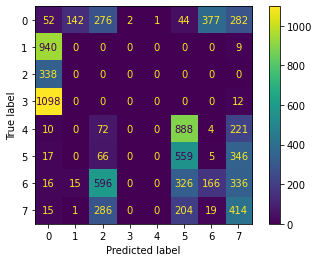

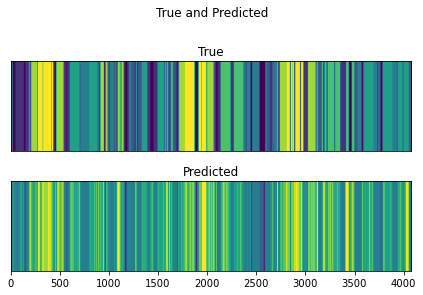

0.4010301692420898


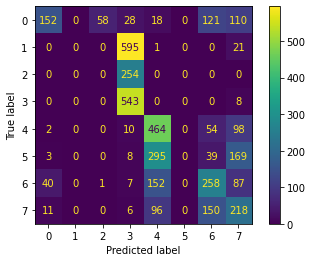

huawei_hmm_recurrent_diagonal_gaussian_100000_10000_random


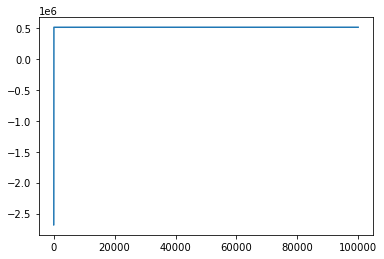

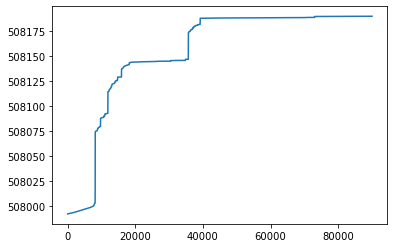

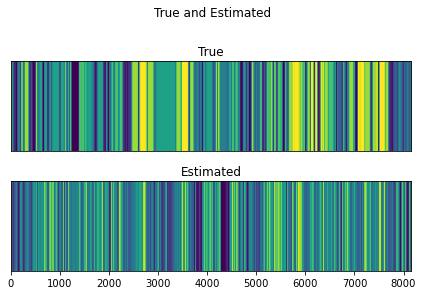

0.05714285714285714


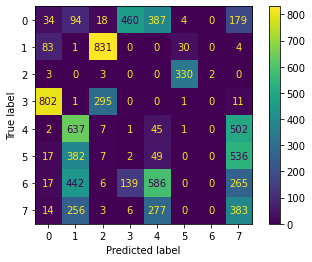

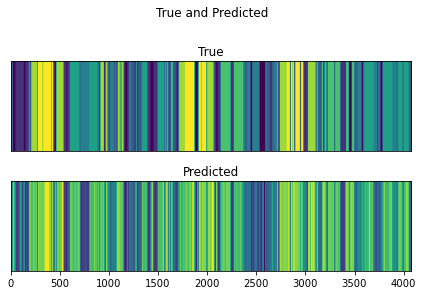

0.5099337748344371


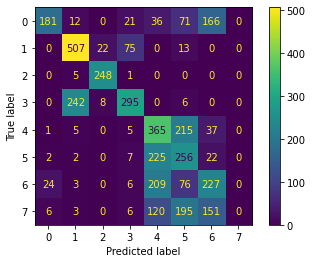

huawei_hmm_standard_diagonal_gaussian_10000_10000_random


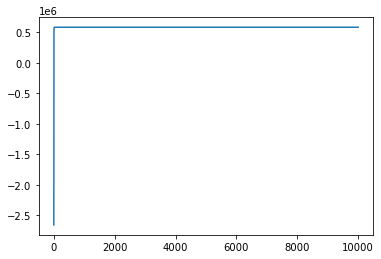

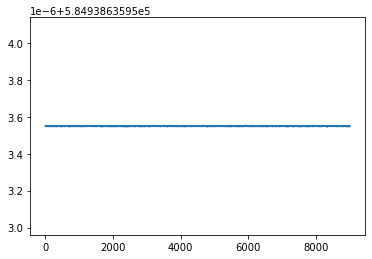

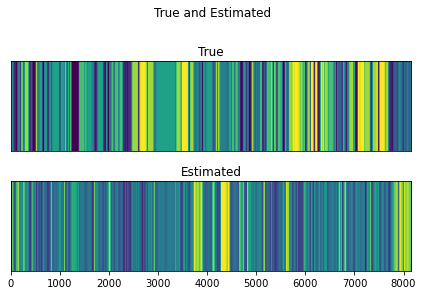

0.13623543838136112


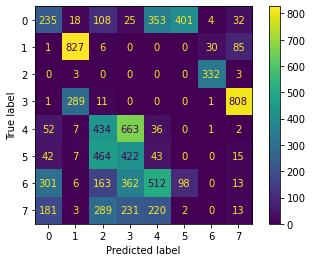

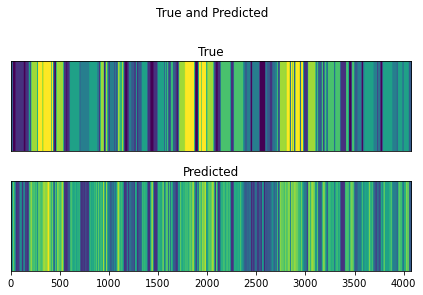

0.519009075300466


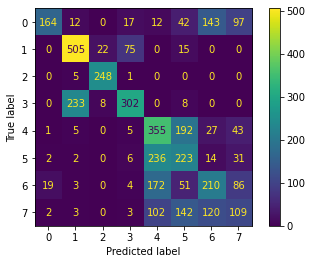

huawei_hmm_standard_diagonal_gaussian_10000_10000_kmeans


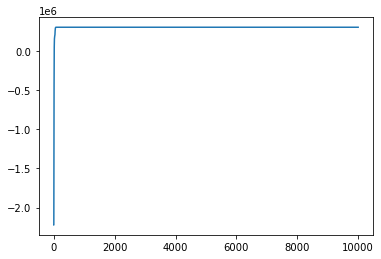

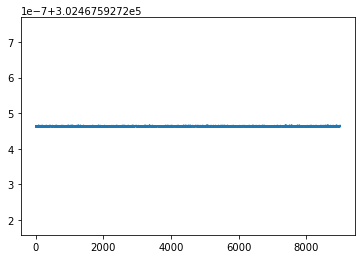

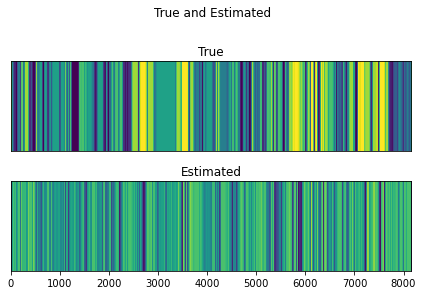

0.1823421213979154


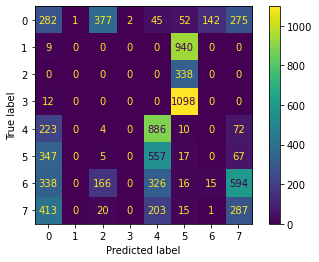

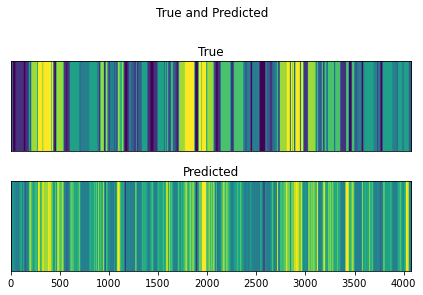

0.400784890851116


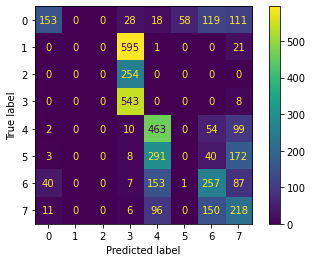

In [16]:
for f_name, model_dic in models_dic.items():
    prefix = f_name[:-7]
    print(prefix)
    model = model_dic["arhmm"]
    lls = model_dic["hmm_lls"]
    most_likely = model_dic["most_likely"]
    mutual_info = mutual_info_classif(X_train, )
    plt.plot(lls)
    plt.show()
    l = len(lls) // 10
    plt.plot(lls[l:])
    plt.show()
    plot_states(y_train, most_likely, "Estimated", prefix)
    print(accuracy_score(y_train, most_likely))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_train, most_likely))
    disp.plot()
    plt.show()
    y_predicted = model.most_likely_states(X_val)
    plot_states(y_val, y_predicted, "Predicted", prefix)
    print(accuracy_score(y_val, y_predicted))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_predicted))
    disp.plot()
    plt.show()

In [ ]:
"test"

In [ ]:
plot_states(y_train, models[0]["most_likely"], "estimated", 0 )

In [ ]:
accuracy_score(y_train, models[1]["most_likely"])

In [ ]:
confusion_matrix(y_train, models[1]["most_likely"])

In [ ]:
posterior_x = posterior.mean_continuous_states[0]
most_likely = rslds.most_likely_states(posterior_x, X_train)

In [ ]:
y_train

In [ ]:
# try:
perm = find_permutation(y_train.astype(int), most_likely)
rslds.permute(perm)
# except:
#     logging.error("Prediction exception")

In [ ]:
z_est = rslds.most_likely_states(posterior_x, X_train)
plot_states(y_train, z_est, "Predicted", 0)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
accuracy_score(y_train, z_est)

In [ ]:
confusion_matrix(y_train, z_est)

In [ ]:
print(models[0]['hmm_lls'])

In [ ]:
plt.plot(models[1]['hmm_lls'][1000:])

In [ ]:
"test"